# Postprocessing on the axis

In [2086]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import ast
from scipy.spatial.transform import Rotation 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Import video

In [2087]:
video_number = "7"
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / f"recording_{video_number}" / f"Recording_{video_number}.mp4" 
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")
fps = round(cap.get(cv2.CAP_PROP_FPS))

Opened: True, FPS: 59.94018018162597, Total Frames: 332.0


Import data

In [2088]:
# Define the path to the CSV file
input_data_path = project_root / "notebook" / "spin" / "intermediate_data" / f"Axis_{video_number}.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(input_data_path)

Plots

In [ ]:
# plot separately the evolution of x, y, z 
def plot_axis_components_over_time(df, title="Axis of Rotation Over Time"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True, sharey=True)

    axes[0].plot(df.index, df['axis_x'], label='X', color='r')
    axes[0].set_title('X Component')
    axes[0].set_xlabel('Frame Index')
    axes[0].set_ylabel('Axis Component Value')
    axes[0].grid(True)

    axes[1].plot(df.index, df['axis_y'], label='Y', color='g')
    axes[1].set_title('Y Component')
    axes[1].set_xlabel('Frame Index')
    axes[1].grid(True)

    axes[2].plot(df.index, df['axis_z'], label='Z', color='b')
    axes[2].set_title('Z Component')
    axes[2].set_xlabel('Frame Index')
    axes[2].grid(True)

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# 3d plot with arrows, not really good
def plot_axis_3d_quiver(df, step=10, scale=0.5):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Use every `step`-th axis for clarity
    data = df.dropna(subset=['axis_x', 'axis_y', 'axis_z'])
    indices = data.index[::step]
    origins = np.zeros((len(indices), 3))  # origin at (0,0,0) for each
    dirs = data.loc[indices, ['axis_x', 'axis_y', 'axis_z']].values

    ax.quiver(origins[:, 0], origins[:, 1], origins[:, 2],
              dirs[:, 0], dirs[:, 1], dirs[:, 2],
              length=scale, normalize=True, color='blue')

    ax.set_title("3D View of Smoothed Axes of Rotation")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.tight_layout()
    plt.show()
    
# plot points on a circle
def plot_points_on_circle(df, step=10):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Use every `step`-th axis for clarity
    data = df.dropna(subset=['axis_x', 'axis_y'])
    indices = data.index[::step]
    points = data.loc[indices, ['axis_x', 'axis_y']].values

    # Plot points
    ax.scatter(points[:, 0], -points[:, 1], color='blue', label='Points')

    # Plot lines between consecutive points
    for i in range(len(points) - 1):
        ax.plot([points[i, 0], points[i + 1, 0]], [-points[i, 1], -points[i + 1, 1]], color='blue', alpha=0.5)

    # Plot circle
    circle = plt.Circle((0, 0), 1, color='lightgray', fill=False, linestyle='--')
    ax.add_artist(circle)

    ax.set_title("Points on Circle from Smoothed Axes of Rotation")
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect('equal', adjustable='datalim')
    ax.legend()
    plt.tight_layout()
    plt.show()
    

Correct flips

In [ ]:
# correct the axis if it is taken in the opposite verse
def correct_flips_df(df):
    df_out = df.copy()
    valid_mask = df_out[['axis_x', 'axis_y', 'axis_z']].notnull().all(axis=1)
    idx = df_out.index[valid_mask]
    axes = df_out.loc[idx, ['axis_x', 'axis_y', 'axis_z']].to_numpy()

    # Normalize
    axes = axes / np.linalg.norm(axes, axis=1, keepdims=True)

    # Flip correction
    corrected = [axes[0]]
    for i in range(1, len(axes)):
        if np.dot(corrected[-1], axes[i]) < 0:
            corrected.append(-axes[i])
            print(f"Flipped: {i}")
            corrected.append(axes[i])
    corrected = np.array(corrected)

    # Replace
    df_out.loc[idx, ['axis_x', 'axis_y', 'axis_z']] = corrected
    return df_out

Smooth axis

In [ ]:
# smoothing
def smooth_axes_df(df, window=5):
    df_out = df.copy()
    valid_mask = df_out[['axis_x', 'axis_y', 'axis_z']].notnull().all(axis=1)
    idx = df_out.index[valid_mask]
    axes = df_out.loc[idx, ['axis_x', 'axis_y', 'axis_z']].to_numpy()

    # Normalize
    axes = axes / np.linalg.norm(axes, axis=1, keepdims=True)

    # Moving average smoothing
    smoothed = []
    for i in range(len(axes)):
        start = max(0, i - window // 2)
        end = min(len(axes), i + window // 2 + 1)
        avg = np.mean(axes[start:end], axis=0)
        avg /= np.linalg.norm(avg)
        smoothed.append(avg)
    smoothed = np.array(smoothed)

    df_out.loc[idx, ['axis_x', 'axis_y', 'axis_z']] = smoothed

    first_valid_index = df['x'].first_valid_index()
    last_valid_index = df['x'].last_valid_index()
    for col in ['axis_x', 'axis_y', 'axis_z']:
        df_out.loc[first_valid_index:last_valid_index, col] = df_out.loc[first_valid_index:last_valid_index, col].interpolate(method='linear', limit_direction='both').fillna(method='bfill').fillna(method='ffill')
    return df_out
    


Remove outliers

In [ ]:
# compute angle between 2 axis
def angular_deviation(a, b):
    """Returns the angle in degrees between two unit vectors a and b"""
    dot = np.clip(np.dot(a, b), -1.0, 1.0)
    return np.degrees(np.arccos(dot))

In [ ]:
# remove the outliers, the axis with an agle too big with respect to the previous
def remove_axis_outliers_df(df, window=5, threshold_deg=30):
    df_out = df.copy()
    valid_mask = df_out[['axis_x', 'axis_y', 'axis_z']].notnull().all(axis=1)
    idx = df_out.index[valid_mask]
    axes = df_out.loc[idx, ['axis_x', 'axis_y', 'axis_z']].to_numpy()

    # Normalize
    axes = axes / np.linalg.norm(axes, axis=1, keepdims=True)

    outliers = np.zeros(len(axes), dtype=bool)
    for i in range(len(axes)):
        start = max(0, i - window // 2)
        end = min(len(axes), i + window // 2 + 1)
        avg = np.mean(axes[start:end], axis=0)
        avg /= np.linalg.norm(avg)
        angle = angular_deviation(axes[i], avg)
        if angle > threshold_deg:
            outliers[i] = True

    df_out.loc[idx[outliers], ['axis_x', 'axis_y', 'axis_z']] = np.nan
    return df_out

Interpolate missing coordinates

In [ ]:
# interpolation function to fill the removed values
def interpolate_axes_df(df):
    df_out = df.copy()
    first_valid_index = df['axis_x'].first_valid_index()
    last_valid_index = df['axis_x'].last_valid_index()
    for col in ['axis_x', 'axis_y', 'axis_z']:
        df_out.loc[first_valid_index:last_valid_index, col] = df_out.loc[first_valid_index:last_valid_index, col].interpolate(method='linear', limit_direction='both')
    return df_out

Try to fix the behavior

In [ ]:
# Constraints the x to be only increasing and the y to be only decreasing (not very good, not real)
def fix_behavior_df(df):
    df_out = df.copy()

    
    for i in range(1, len(df_out)):
        if not pd.isna(df_out.loc[i-1, 'axis_x']) and not pd.isna(df_out.loc[i-1, 'axis_y']) and not pd.isna(df_out.loc[i-1, 'axis_z']):
            # Ensure axis_x values can only increase in absolute value
            if abs(df_out.loc[i, 'axis_x']) < abs(df_out.loc[i - 1, 'axis_x']):
                df_out.loc[i, 'axis_x'] = df_out.loc[i - 1, 'axis_x']

            # Ensure axis_y values can only decrease in absolute value
            if abs(df_out.loc[i, 'axis_y']) > abs(df_out.loc[i - 1, 'axis_y']):
                df_out.loc[i, 'axis_y'] = df_out.loc[i - 1, 'axis_y']

            df_out.loc[i, 'axis_z'] = np.sqrt(1 - df_out.loc[i, 'axis_x']**2 - df_out.loc[i, 'axis_y']**2)
            # Recalculate axis_z
            if df_out.loc[i, 'axis_z'] * df_out.loc[i - 1, 'axis_z'] < 0:
                df_out.loc[i, 'axis_z'] = -df_out.loc[i, 'axis_z']

    return df_out

Try to fix multiplying with a line

In [ ]:
# multipli x and y with two lines to simulate the correct behavior
def fix_lines_df(df):
    df_out = df.copy()
    first_valid_index = df['axis_x'].first_valid_index()
    last_valid_index = df['axis_x'].last_valid_index()
    line_y = np.linspace(1, 0, num=last_valid_index - first_valid_index + 1)
    line_x = np.linspace(1, 1/df.loc[last_valid_index, 'axis_x'], num=last_valid_index - first_valid_index + 1)

    df_out.loc[first_valid_index:last_valid_index, 'axis_x'] = line_x * df_out.loc[first_valid_index:last_valid_index, 'axis_x']
    df_out.loc[first_valid_index:last_valid_index, 'axis_y'] = np.minimum(line_y * df_out.loc[first_valid_index:last_valid_index, 'axis_y'], 1)
    for i in range(first_valid_index, last_valid_index + 1):
        df_out.loc[i, 'axis_x'] = np.clip(line_x[i-first_valid_index] * df_out.loc[i, 'axis_x'], -1, 1)
    sign = np.sign(df_out.loc[first_valid_index, 'axis_z'])
    # Calculate axis_z and handle cases where the value inside sqrt is negative
    axis_z_squared = 1 - df_out.loc[first_valid_index:last_valid_index, 'axis_x']**2 - df_out.loc[first_valid_index:last_valid_index, 'axis_y']**2
    df_out.loc[first_valid_index:last_valid_index, 'axis_z'] = np.where(axis_z_squared < 0, 0, sign * np.sqrt(axis_z_squared))

    # Normalize the axis
    norm = np.sqrt(df_out.loc[first_valid_index:last_valid_index, 'axis_x']**2 +
                   df_out.loc[first_valid_index:last_valid_index, 'axis_y']**2 +
                   df_out.loc[first_valid_index:last_valid_index, 'axis_z']**2)
    df_out.loc[first_valid_index:last_valid_index, ['axis_x', 'axis_y', 'axis_z']] = df_out.loc[first_valid_index:last_valid_index, ['axis_x', 'axis_y', 'axis_z']].div(norm, axis=0)

    return df_out

Postprocessing

In [ ]:
def process_axis_dataframe(df, window_outliers=15, window_smooth=5):

    plot_axis_components_over_time(df, 'raw data')


    df_no_outliers = remove_axis_outliers_df(df, window=window_outliers)
    plot_axis_components_over_time(df_no_outliers, 'outliers removed')

    df_interpolated = interpolate_axes_df(df_no_outliers)
    plot_axis_components_over_time(df_interpolated, 'interpolated')

    df_smoothed = smooth_axes_df(df_interpolated, window=window_smooth)
    plot_axis_components_over_time(df_smoothed, 'smoothed')

    return df_smoothed

Main 

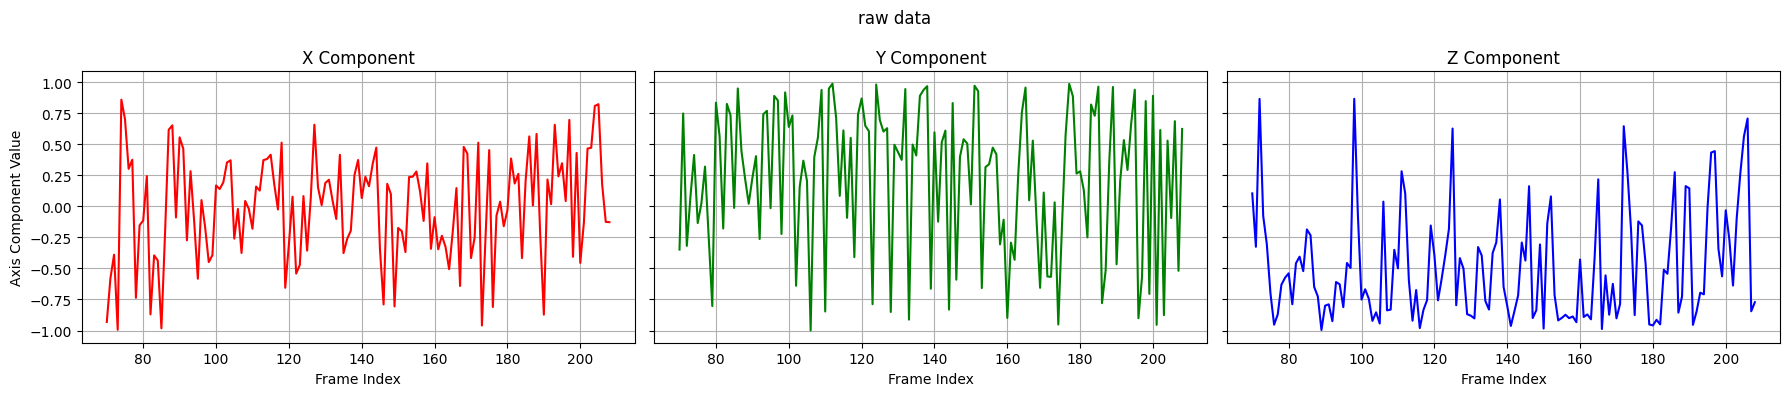

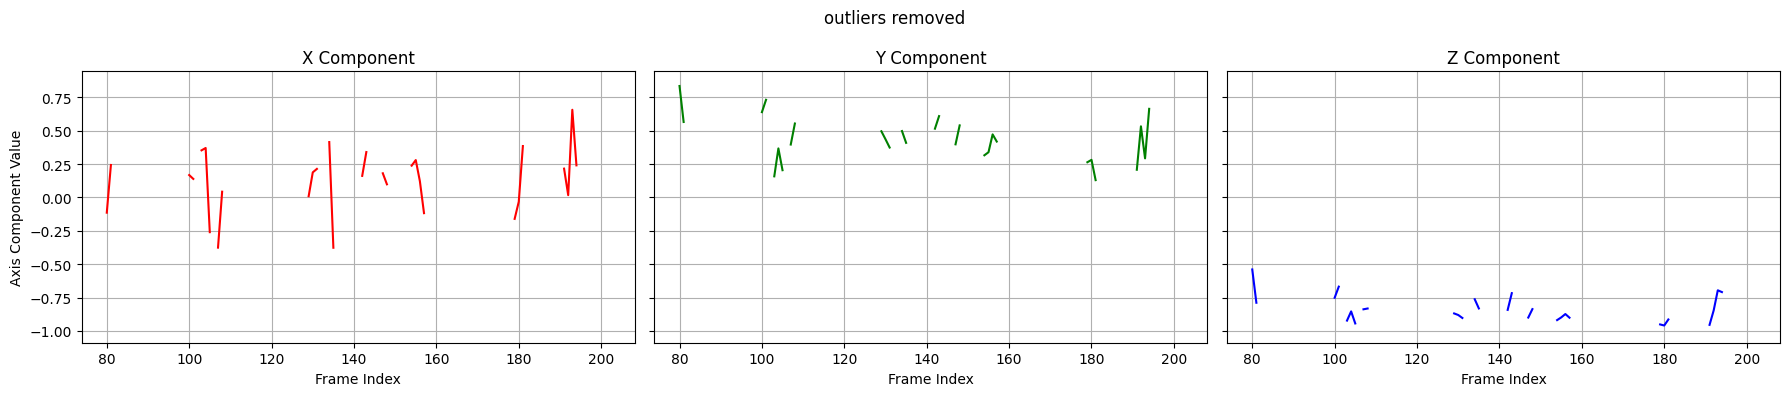

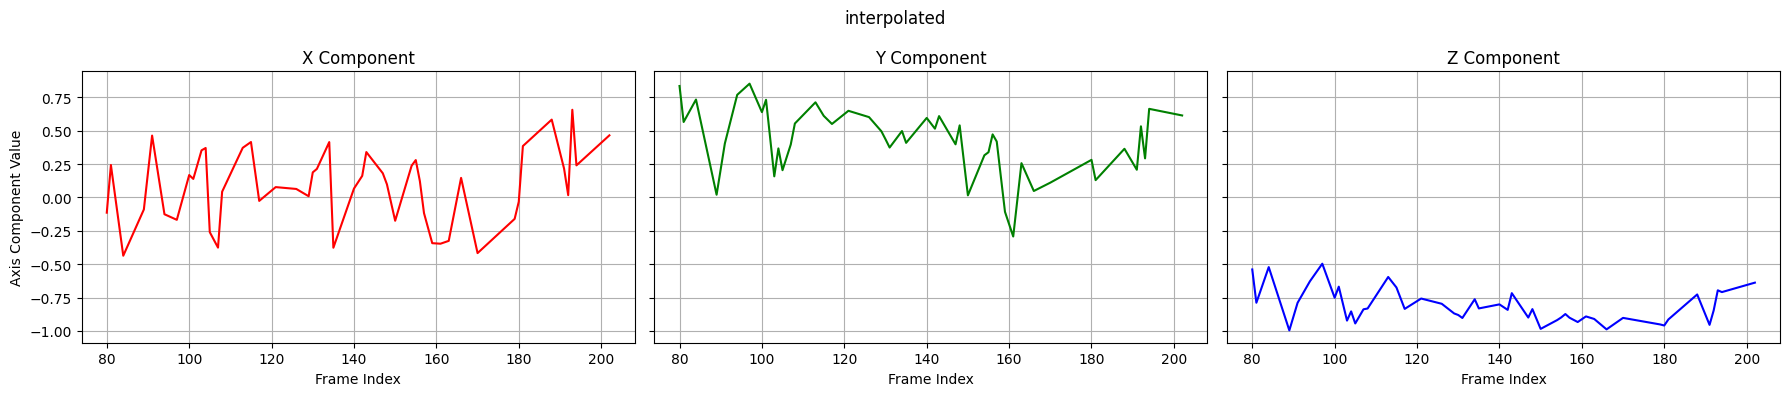

C:\Users\miche\AppData\Local\Temp\ipykernel_16248\1951917951.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_out.loc[first_valid_index:last_valid_index, col] = df_out.loc[first_valid_index:last_valid_index, col].interpolate(method='linear', limit_direction='both').fillna(method='bfill').fillna(method='ffill')
C:\Users\miche\AppData\Local\Temp\ipykernel_16248\1951917951.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_out.loc[first_valid_index:last_valid_index, col] = df_out.loc[first_valid_index:last_valid_index, col].interpolate(method='linear', limit_direction='both').fillna(method='bfill').fillna(method='ffill')
C:\Users\miche\AppData\Local\Temp\ipykernel_16248\1951917951.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.

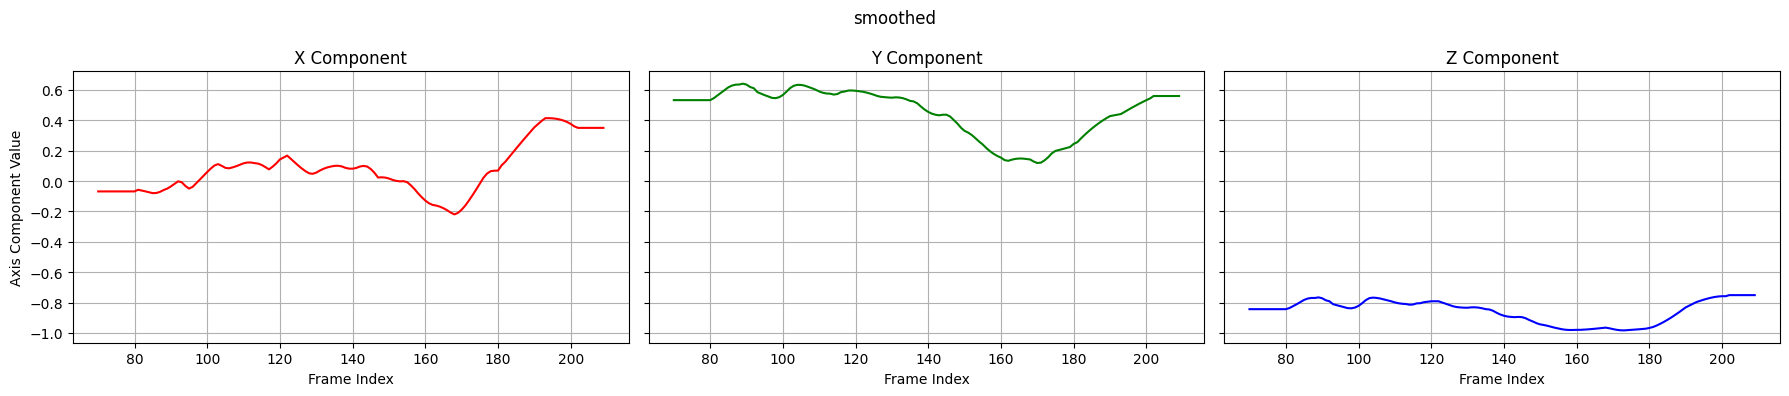

C:\Users\miche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


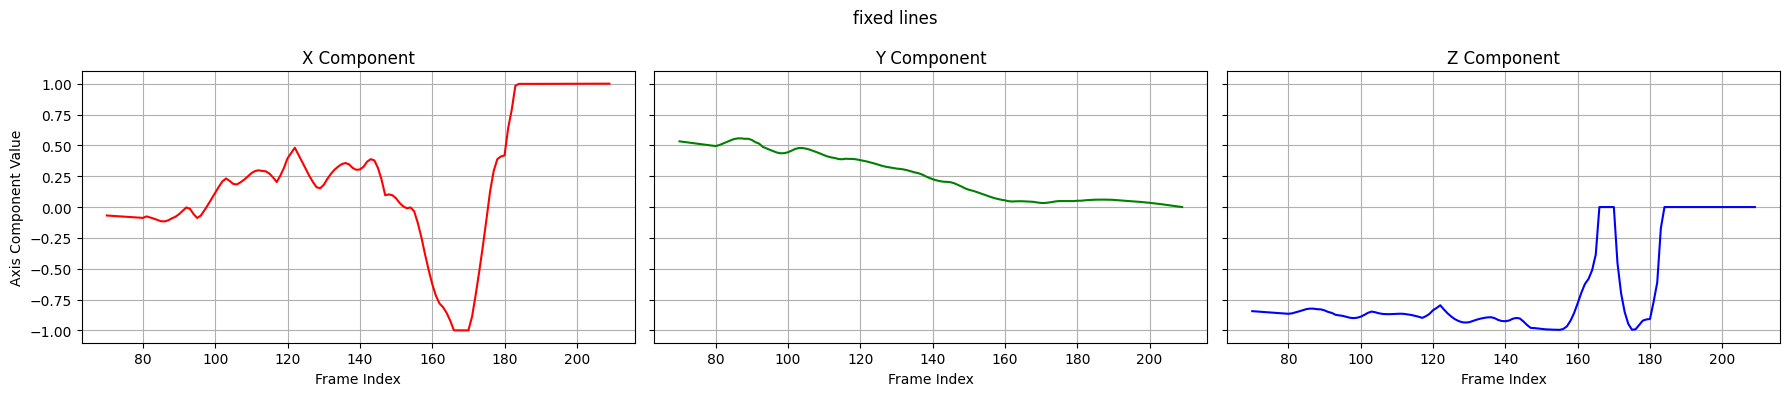

In [ ]:
df_processed = process_axis_dataframe(df, window_outliers=35, window_smooth=25)


## Postprocess the rotation angle

Functions

In [ ]:
# Plot the evolution of the rotation angle
def plot_angle_over_index(df, title="Angle Over Index"):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['angle'], label='Angle', color='blue')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Angle (rad)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Outliers removal, z-score
def remove_outliers(series, threshold=1):
    # Apply an outlier removal using z-score
    mean = series.mean()
    std = series.std()
    z_scores = (series - mean) / std
    outliers_z = abs(z_scores) > threshold  # Consider values with z-score > threshold as outliers
    series[outliers_z] = np.nan

    return series

In [ ]:
# Smoothing woth rolling
def smooth_series(series, first_valid_index, last_valid_index, window=5):
    # Copia per non modificare l'originale
    smoothed = series.copy()

    # Applichi il rolling solo tra i validi
    rolled = series[first_valid_index:last_valid_index+1] \
        .rolling(window=window, center=True) \
        .mean()

    # Interpolazione per stimare i bordi più precisamente
    rolled = rolled.interpolate(method='cubic', limit_direction='both').fillna(method='bfill').fillna(method='ffill')

    smoothed[first_valid_index:last_valid_index+1] = rolled

    # Rimetti i valori smussati nella serie originale
    series.loc[first_valid_index:last_valid_index] = smoothed
    return series

Processing

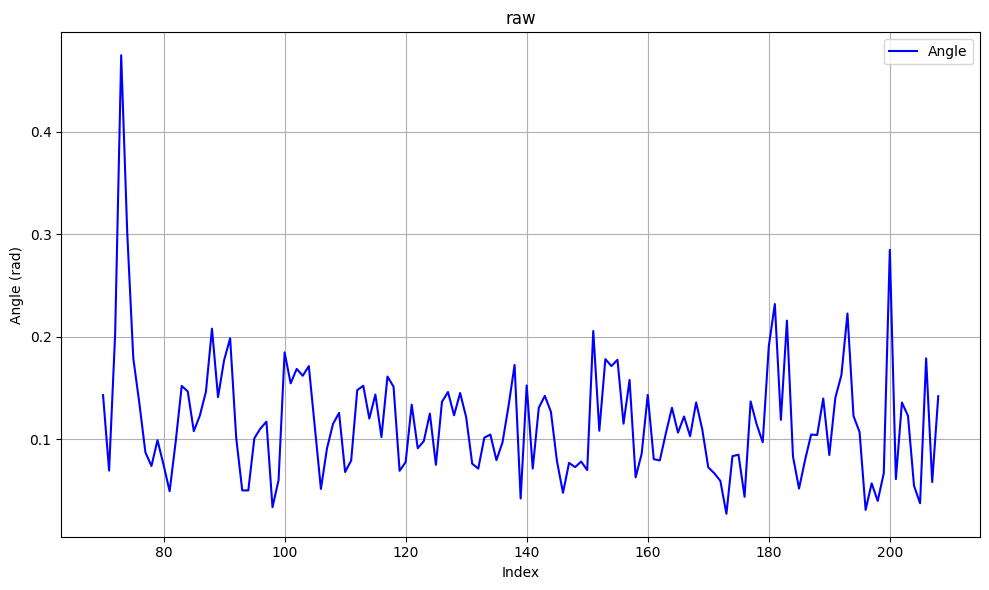

C:\Users\miche\AppData\Local\Temp\ipykernel_16248\1482545196.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series[outliers_z] = np.nan


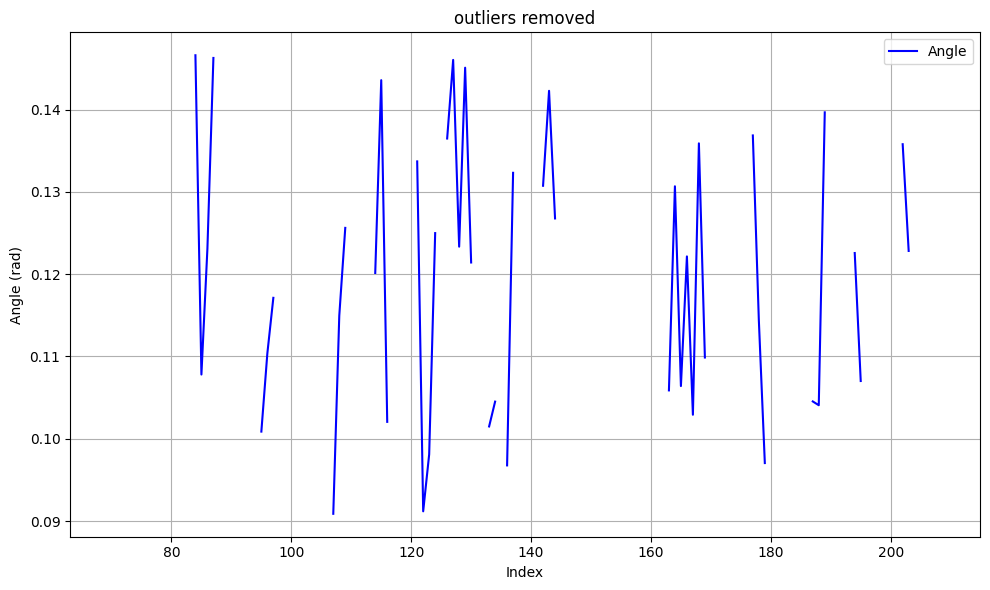

First valid index: 70, Last valid index: 209


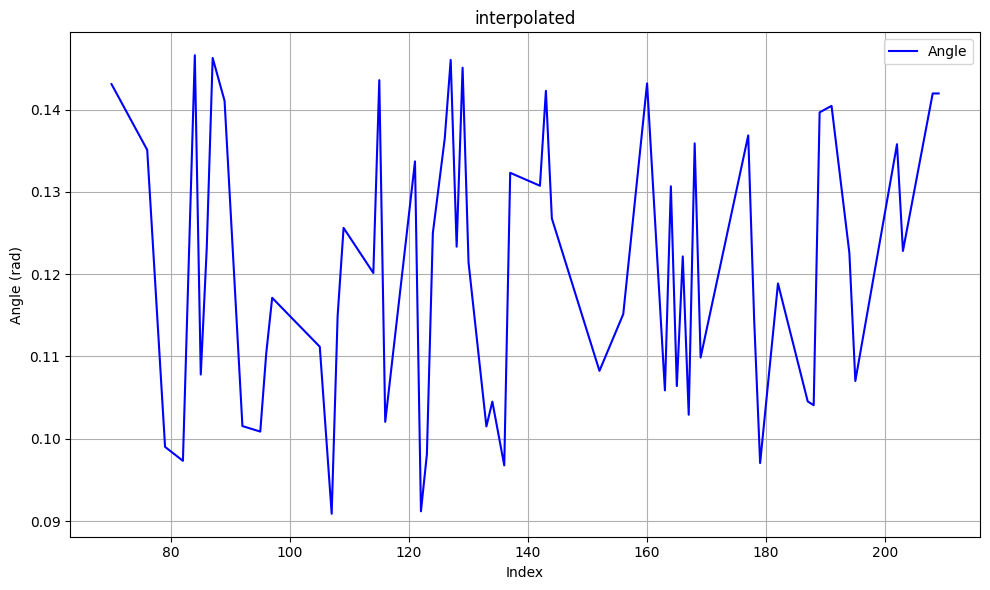

C:\Users\miche\AppData\Local\Temp\ipykernel_16248\1482545196.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolled = rolled.interpolate(method='cubic', limit_direction='both').fillna(method='bfill').fillna(method='ffill')
C:\Users\miche\AppData\Local\Temp\ipykernel_16248\1482545196.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[first_valid_index:last_valid_index] = smoothed


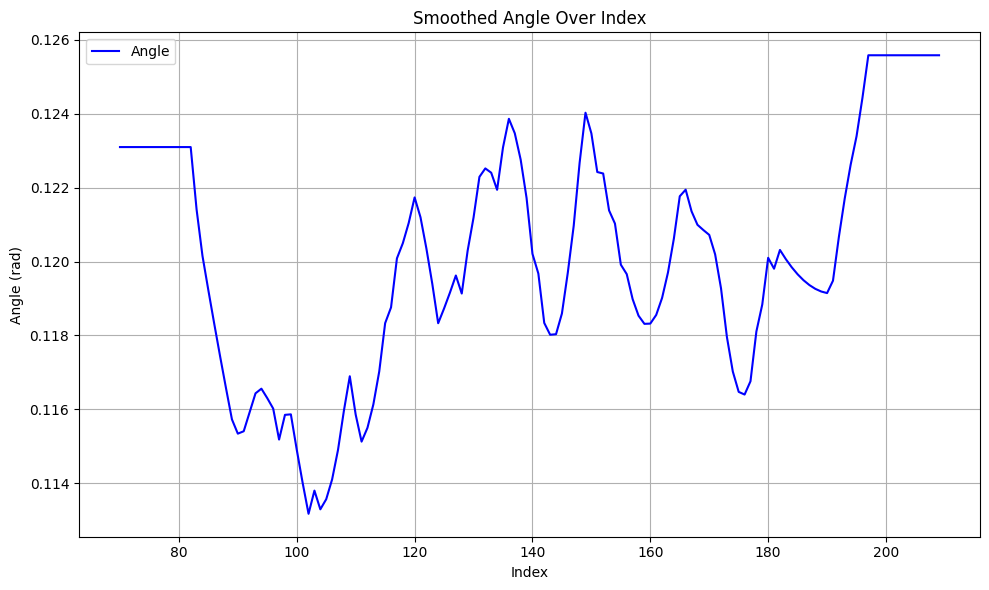

In [ ]:
plot_angle_over_index(df, title="raw")

# Remove outliers
df['angle'] = remove_outliers(df['angle'], threshold=0.5)
plot_angle_over_index(df, title="outliers removed")

# Find the first and last non-NaN indices
first_valid_index = df_processed['x'].first_valid_index()
last_valid_index = df_processed['x'].last_valid_index()
print(f"First valid index: {first_valid_index}, Last valid index: {last_valid_index}")

# Only interpolate between them
df.loc[first_valid_index:last_valid_index, 'angle'] = (
    df.loc[first_valid_index:last_valid_index, 'angle']
    .interpolate(method='linear', limit_direction='both')
)
plot_angle_over_index(df, title="interpolated")

# Smooth the data
df['angle'] = smooth_series(df['angle'], first_valid_index, last_valid_index, window=25)

plot_angle_over_index(df, title="Smoothed Angle Over Index")

# Assign the processed data to the correct df
df_processed['angle'] = df['angle']

Generate video

In [ ]:
# Define the output video path
output_video_path = str(project_root / "data" / f"recording_{video_number}" / "test_video" / f"Spin_processed_axis_{video_number}_circle.mp4")

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
frame_width = 1080  # Set the width and height for the circle video
frame_height = 1080
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Iterate through the video frames
frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Create a blank frame with a circle
    circle_frame = np.zeros((frame_height, frame_width, 3), dtype=np.uint8)
    center_circle = (frame_width // 2, frame_height // 2)
    radius_circle = 500
    cv2.circle(circle_frame, center_circle, radius_circle, (0, 0, 255), -1)  # Draw the circle

    # Check if the current frame index exists in the DataFrame
    if frame_idx in df_processed.index:
        row = df_processed.loc[frame_idx]
        if not pd.isna(row['x']) and not pd.isna(row['y']) and not pd.isna(row['radius']):
            # Draw the center of the ball
            center = (int(center_circle[0] + row['x']), int(center_circle[1] - row['y']))

            # Calculate and draw the intersection of the axis with the ball
            axis = np.array([row['axis_x'], row['axis_y'], row['axis_z']])
            if not np.any(np.isnan(axis)):
                axis = axis / np.linalg.norm(axis)  # Normalize the axis
                intersection = center_circle + radius_circle * axis[:2]  # Project onto 2D
                intersection = (int(intersection[0]), int(intersection[1]))
                int_2 = center_circle - radius_circle * axis[:2]
                int_2 = (int(int_2[0]), int(int_2[1]))
                cv2.circle(circle_frame, intersection, 10, (0, 255, 255), -1) 
                cv2.circle(circle_frame, int_2, 10, (255, 255, ), -1)
                cv2.circle(circle_frame, center_circle, 10, (255, 0, 0), -1)
                cv2.line(circle_frame, intersection, int_2, (0, 255, 0), 2)
                
                # Draw the 3D equator perpendicular to the axis
                if not np.any(np.isnan(axis)):
                    # Generate points on a circle in 3D
                    theta = np.linspace(0, 2 * np.pi, 100)
                    circle_points = np.array([np.cos(theta), np.sin(theta), np.zeros_like(theta)]).T

                    # Find a rotation matrix to align the Z-axis with the axis vector
                    axis_normalized = axis / np.linalg.norm(axis)
                    z_axis = np.array([0, 0, 1])
                    if not np.allclose(axis_normalized, z_axis):
                        rotation_vector = np.cross(z_axis, axis_normalized)
                        rotation_angle = np.arccos(np.dot(z_axis, axis_normalized))
                        rotation_matrix = Rotation.from_rotvec(rotation_angle * rotation_vector / np.linalg.norm(rotation_vector)).as_matrix()
                    else:
                        rotation_matrix = np.eye(3)

                    # Rotate the circle points
                    rotated_circle_points = circle_points @ rotation_matrix.T

                    # Project the 3D points onto the 2D plane
                    projected_points = center_circle + radius_circle * rotated_circle_points[:, :2]

                    # Draw the equator
                    for i in range(len(projected_points) - 1):
                        pt1 = (int(projected_points[i, 0]), int(projected_points[i, 1]))
                        pt2 = (int(projected_points[i + 1, 0]), int(projected_points[i + 1, 1]))
                        cv2.line(circle_frame, pt1, pt2, (255, 255, 0), 1)

                    # Draw additional circles parallel to the equator
                    for offset in [-0.6, -0.3, 0.3, 0.6]:  # Adjust the offset for the additional circles
                        radius = np.sqrt(1 - offset**2) * radius_circle  # Calculate the radius of the circle at this offset
                        offset_circle_points = np.array([np.cos(theta), np.sin(theta), np.full_like(theta, offset)]).T
                        rotated_offset_circle_points = offset_circle_points @ rotation_matrix.T
                        # select the points with z>0
                        # rotated_offset_circle_points = rotated_offset_circle_points[rotated_offset_circle_points[:, 2] > 0]
                        projected_offset_points = center_circle + radius * rotated_offset_circle_points[:, :2]

                        for j in range(len(projected_offset_points) - 1):
                            pt1 = (int(projected_offset_points[j, 0]), int(projected_offset_points[j, 1]))
                            pt2 = (int(projected_offset_points[j + 1, 0]), int(projected_offset_points[j + 1, 1]))
                            cv2.line(circle_frame, pt1, pt2, (255, 255, 0), 1)

    # Write the frame to the output video
    out.write(circle_frame)
    frame_idx += 1

# Release resources
out.release()
print(f"Annotated video with circle saved to {output_video_path}")

Video palla affiencata

In [ ]:
# Define the output path for the cropped video with a black square
cropped_ball_with_black_square_video_path = project_root / "data" / f"recording_{video_number}" / "test_video" / f"spin_axis_double_{video_number}.mp4"
#get the width and height of the video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

crop_size = 80

# Initialize the VideoWriter for the cropped video with a black square
cropped_ball_with_black_square_out = cv2.VideoWriter(
    str(cropped_ball_with_black_square_video_path), fourcc, fps, (2 * 2 * crop_size, 2 * crop_size)
)

# Reset the video to the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Iterate through all frames of the video
frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Check if the current frame index exists in ball_df
    if frame_idx in df_processed.index:
        # Get the row corresponding to the current frame index
        row = df.iloc[frame_idx]

        # Ensure the ball center coordinates and radius are valid
        if not math.isnan(row['x']) and not math.isnan(row['y']) and not math.isnan(row['radius']):
            center_x = int(row['x'])
            center_y = int(row['y'])
            radius = crop_size

            # Define the cropping region
            x_start = max(center_x - radius, 0)
            y_start = max(center_y - radius, 0)
            x_end = min(center_x + radius, frame_width)
            y_end = min(center_y + radius, frame_height)
            
            # Crop the frame
            cropped_frame = frame[y_start:y_end, x_start:x_end]

            # Resize the cropped frame to the desired size
            cropped_frame_resized = cv2.resize(cropped_frame, (2 * crop_size, 2 * crop_size))

            # Create a black square with the same dimensions as the cropped frame
            black_square = np.zeros_like(cropped_frame_resized)

            # Draw a red circle inside the black square
            cv2.circle(black_square, (crop_size, crop_size), 70, (0, 0, 255), -1)
            cv2.circle(black_square, (crop_size, crop_size), 5, (255, 0, 0), -1)
            # Draw the rotation center if rotation_center_x and rotation_center_y are not NaN
            if not math.isnan(df_processed.loc[frame_idx]['axis_x']) and not math.isnan(df_processed.loc[frame_idx]['axis_y']):
                rotation_center_x1 = int((df_processed.loc[frame_idx]['axis_x'] * 70) + crop_size)
                rotation_center_y1 = int((df_processed.loc[frame_idx]['axis_y'] * 70) + crop_size)

                rotation_center_x2 = int((-df_processed.loc[frame_idx]['axis_x'] * 70) + crop_size)
                rotation_center_y2 = int((-df_processed.loc[frame_idx]['axis_y'] * 70) + crop_size)
                
                # rotation_center_x = int(valid_data_no_outliers.loc[frame_idx]['smoothed_']) - x_start
                # rotation_center_y = int(valid_data_no_outliers.loc[frame_idx]['rotation_center_y']) - y_start
                if 0 <= rotation_center_x1 < cropped_frame_resized.shape[1] and 0 <= rotation_center_y1 < cropped_frame_resized.shape[0]:
                    cv2.line(black_square, (rotation_center_x1, rotation_center_y1), (rotation_center_x2, rotation_center_y2), (0, 255, 0), 2)
                    cv2.circle(black_square, (rotation_center_x1, rotation_center_y1), 2, (0, 255, 255), -1)
                    cv2.circle(black_square, (rotation_center_x2, rotation_center_y2), 2, (255, 255, ), -1)
                    
                
                axis = np.array([df_processed.loc[frame_idx]['axis_x'], df_processed.loc[frame_idx]['axis_y'], df_processed.loc[frame_idx]['axis_z']])
                # Draw the 3D equator perpendicular to the axis
                if not np.any(np.isnan(axis)):
                    # Generate points on a circle in 3D
                    theta = np.linspace(0, 2 * np.pi, 100)
                    circle_points = np.array([np.cos(theta), np.sin(theta), np.zeros_like(theta)]).T

                    # Find a rotation matrix to align the Z-axis with the axis vector
                    axis_normalized = axis / np.linalg.norm(axis)
                    z_axis = np.array([0, 0, 1])
                    if not np.allclose(axis_normalized, z_axis):
                        rotation_vector = np.cross(z_axis, axis_normalized)
                        rotation_angle = np.arccos(np.dot(z_axis, axis_normalized))
                        rotation_matrix = Rotation.from_rotvec(rotation_angle * rotation_vector / np.linalg.norm(rotation_vector)).as_matrix()
                    else:
                        rotation_matrix = np.eye(3)

                    # Rotate the circle points
                    rotated_circle_points = circle_points @ rotation_matrix.T

                    # Project the 3D points onto the 2D plane
                    projected_points = (crop_size, crop_size) + 70 * rotated_circle_points[:, :2]

                    # Draw the equator
                    for i in range(len(projected_points) - 1):
                        pt1 = (int(projected_points[i, 0]), int(projected_points[i, 1]))
                        pt2 = (int(projected_points[i + 1, 0]), int(projected_points[i + 1, 1]))
                        cv2.line(black_square, pt1, pt2, (255, 255, 0), 1)

                    
                        
            # Concatenate the cropped frame and the black square horizontally
            combined_frame = np.hstack((cropped_frame_resized, black_square))

     
            # Write the combined frame to the output video
            cropped_ball_with_black_square_out.write(combined_frame)

    # Increment the frame index
    frame_idx += 1

# Release resources
cropped_ball_with_black_square_out.release()

print(f"Cropped ball video with black square saved at: {cropped_ball_with_black_square_video_path}")


Cropped ball video with black square saved at: C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\data\recording_7\test_video\spin_axis_double_7.mp4


Save data in csv file 

In [2102]:
output_data_path = project_root / "notebook" / "spin" / "intermediate_data" / f"Axis_{video_number}_processed.csv"
df_processed.to_csv(output_data_path, index=False)
print(f"Processed axis data saved to: {output_data_path}")

Processed axis data saved to: C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\notebook\spin\intermediate_data\Axis_7_processed.csv
